Creating a custom CNN for detection of cancer from histology specimens.

##first imports for torch, torchvision, numpy, pandas, and os

In [0]:
# Imports here
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip uninstall -y Pillow
!pip install Pillow==5.3.0

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import PIL

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


In [0]:
import torch
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import PIL
import matplotlib as plt

In [0]:
import os
import pandas as pd
import numpy as np
import shutil

In [0]:
#Set up for cuda usage
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print("{} is available".format(device))

cuda is available


In [0]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/histo_data"

models	train  valid


Below I seprate the training set into sperate train and validation folders -- I left it up to the user to place directories and creat the 0 and 1 subfolders because of different 

In [0]:
# Reorganizing data to subfolders zero and one for pytorch labels implementation as well as seperate into valid folders sperately 
# to seperate image augmentation transforms and validation transforms

labels = pd.read_csv(r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\train_labels.csv''')

training_path = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\\'''
train_path_0 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\0\\'''
train_path_1 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\1\\'''
valid_path_0 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\valid\0\\'''
valid_path_1 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\valid\1\\'''

percent_valid = .15


def file_valid_split_copy_delete(training_path, train_path_0, train_path_1, valid_path_0, valid_path_1, percent_valid):
    counter_0 = 0
    counter_1 = 0
    counter_false = 0
    counter_true = 0
    
    for i in range(len(labels)):
        if labels.label[i] == 0:
            counter_false +=1
        if labels.label[i] == 1:
            counter_true +=1

    train_split_0 = int(percent_valid * counter_false)
    train_split_1 = int(percent_valid * counter_true)

    for i in range(len(labels)):
        file_name = str(labels.id[i]) + '.tif'
        if labels.label[i].item() == 0:
            if counter_0 <= train_split_0:
                file_path_copy = valid_path_0
                counter_0 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)
            else:
                file_path_copy = train_path_0
                counter_0 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)

        elif labels.label[i].item() == 1:
            if counter_1 <= trains_split_1:
                file_path_copy = valid_path_1
                counter_1 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)
            else:
                file_path_copy = train_path_1
                counter_0 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)
                
    print("files have been relocated")
    
    return

In [0]:
file_valid_split_copy_delete(training_path, train_path_0, train_path_1, valid_path_0, valid_path_1, percent_valid)

In [0]:
# Begin to load Data Transforms and split validation set

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load

# percentage of training set to use as validation
#valid_size = 0.15
#file directories
data_dir =  '/content/drive/My Drive/histo_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
#test_dir = data_dir + '/test'

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.Resize(224), 
                                       transforms.RandomRotation(15),
                                       transforms.RandomHorizontalFlip(15),
                                       transforms.ColorJitter(brightness=0.4,
                                                             hue=0.1),
                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

#test_transforms = transforms.Compose([transforms.CenterCrop(32),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])



# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
#test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
#trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
#validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#    num_workers=num_workers)

print(len(valid_loader))

62


In [0]:
for images, labels in train_loader:
  print(labels)

tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])


KeyboardInterrupt: ignored

Visualize data

In [0]:
# helper function to un-normalize and display an image
import matplotlib.pyplot as plt
%matplotlib inline
def imshow(img):
    img = img.transpose((1, 2, 0))
    img = .224*img + .456  # unnormalize
    
    img = np.clip(img, 0, 1)
    plt.imshow(img)  # convert from Tensor image

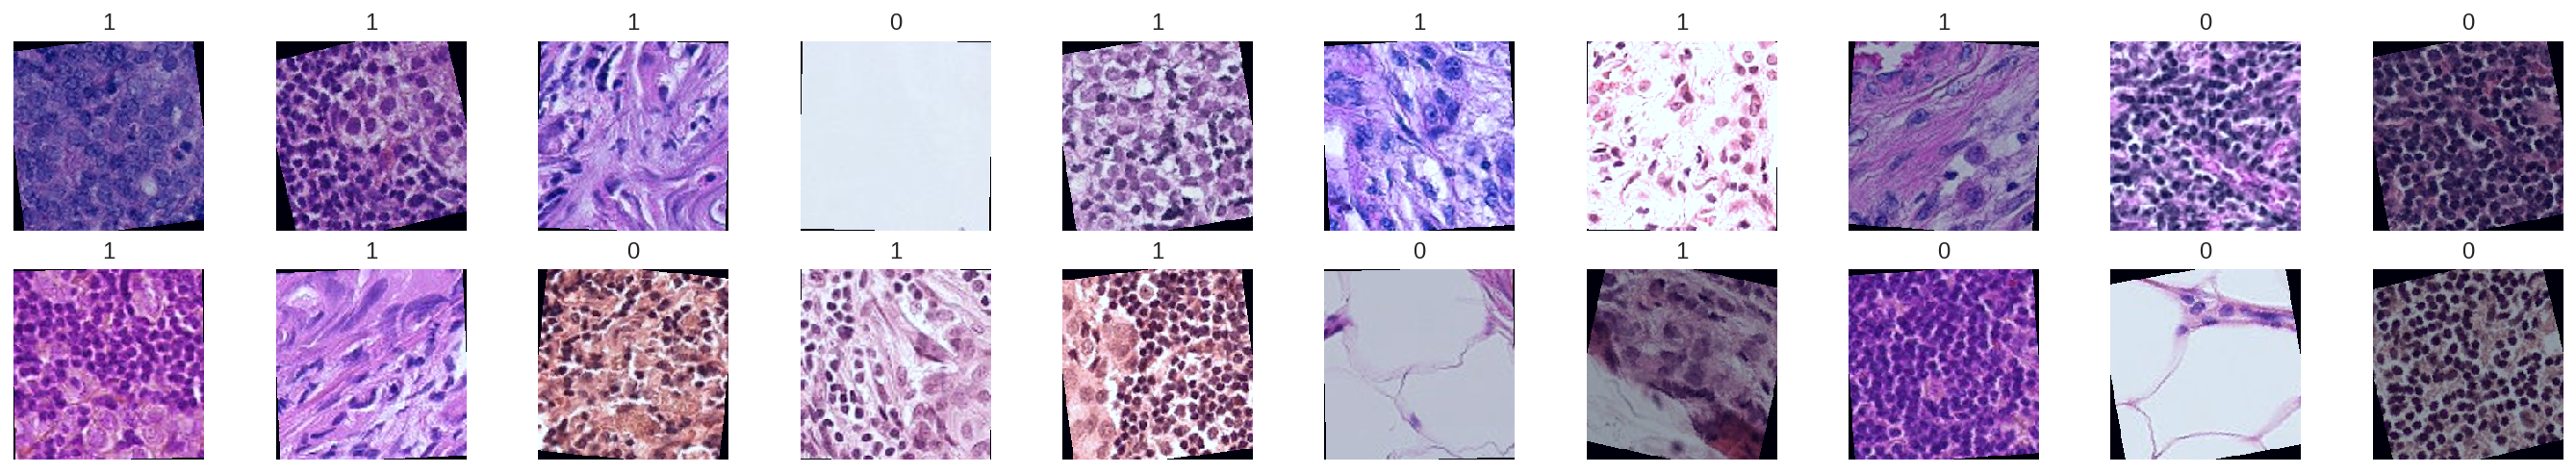

In [18]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(24, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].item())

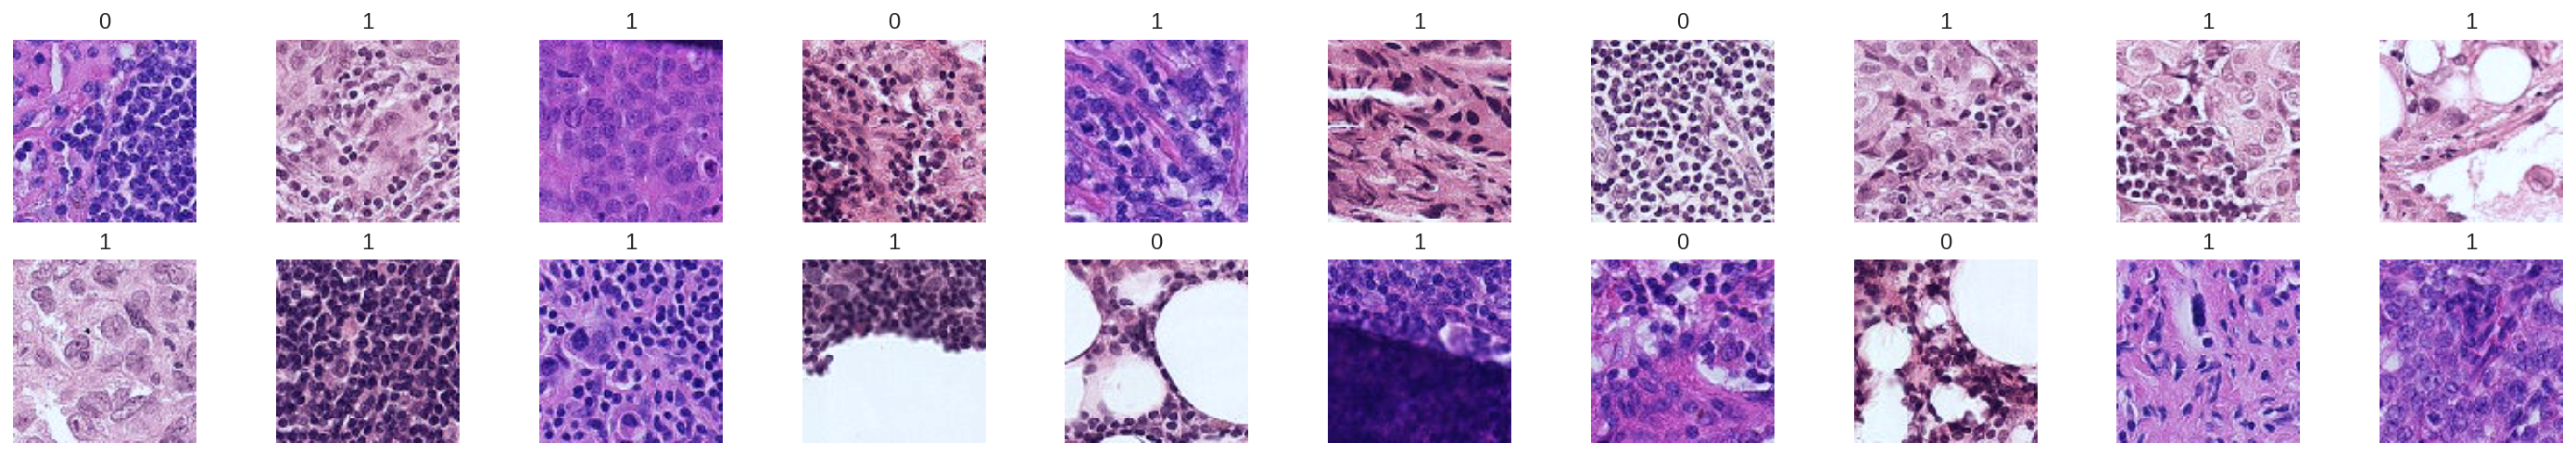

In [19]:
# obtain one batch of training images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].item())

##Time to define our CNN model

In [20]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [21]:
for param in model.parameters():
  param.requires_grad = False
  
from collections import OrderedDict
fc = nn.Sequential(OrderedDict([('hidden_1', nn.Linear(2048, 2))]))

model.fc = fc
for param in model.fc.parameters():
    param.requires_grad = True

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

##Add Optimizer and Loss finctions

In [0]:
from torch.optim import lr_scheduler
criterion = nn.BCELoss()
optimizer = optim.SGD(model.fc.parameters(), lr=.01, momentum=0.99)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
sigmoid = nn.Sigmoid()
softmax = nn.Softmax(dim=1)

In [0]:
def set_array(labels, device):

    outputs_dim_2 = []
    #outputs_dim_2 = [[] for i in range(64)]

    for i in range(len(labels)):
        if labels[i] == 1:
            outputs_dim_2.append([0., 1.])
        else:
            outputs_dim_2.append([1., 0.])

    outputs_dim_2 = np.array(outputs_dim_2)
    outputs_dim_2 = torch.from_numpy(outputs_dim_2)
    outputs_dim_2 = outputs_dim_2.to(device)
    #outputs_dim_2.squeeze(1)
    #print(np.shape(outputs_dim_2))
    #print(outputs_dim_2)

    return outputs_dim_2

#Training Loop

In [24]:
steps = 0
running_loss = 0
epochs = 50
print_every = 10
valid_loss_min = np.Inf

for e in range(epochs):
  model.train()
  model.to(device)
  
  for images, labels in train_loader:
    steps += 1
    #print(steps)
    images, labels = images.to(device), labels.to(device)
    #print(labels)
    optimizer.zero_grad()
    
    output = model.forward(images)
    #print(softmax(output)[:,1])
    new_labels = set_array(labels, device)
    #print(softmax(output), new_labels)
    loss = criterion(softmax(output),new_labels.float())
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    if steps % print_every == 0:
      model.eval()
      
      counter = 0
      accuracy = 0
      test_loss = 0
      with torch.no_grad():
        for images, labels in valid_loader:
          images, labels = images.to(device), labels.to(device)
          new_labels = set_array(labels, device)
          output = model(images)
          test_loss += criterion(softmax(output), new_labels.float()).item()
          #print(softmax(output), labels.float())
          output_sig = softmax(output)
          #print(output_sig, labels)
          #print(output_sig[i].item())
          
          for i in range(len(labels)):
            if output_sig[i][1] >= .5:
              output_acc = 1.
            else:
              output_acc = 0.
            #print(output_acc == labels[i].data.float())
            if output_acc == labels[i].data.float():
              
              accuracy += 1
              
          counter += 1
          print(accuracy, counter)
          #equality = (labels.data == output)
          #accuracy += equality.type_as(torch.FloatTensor()).mean()
          #print(counter)
          #counter += 1
        
      print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss/print_every),
            "Validation Loss: {:.3f}.. ".format(test_loss/len(valid_loader)),
            "Validation Accuracy: {:.3f}".format(accuracy/(counter*64)))
      
      # save model if validation loss has decreased
      valid_loss = test_loss/len(valid_loader)
      
      if valid_loss <= valid_loss_min:
        
        checkpoint = {'batch_size': 64,
                      'valid_transforms': valid_transforms,
                      'train_transforms': train_transforms,
                      'model': model,
                      'classifier': fc,
                      'criterion': criterion,
                      'optimizer': optimizer.state_dict(),
                      'state_dict': model.state_dict()
                      }
        
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.
              format(valid_loss_min, valid_loss))
        
        torch.save(checkpoint,'/content/drive/My Drive/histo_data/models/model_checkpoint.pth')
        valid_loss_min = valid_loss
      
      running_loss = 0
      model.train()
        
        

43 1
83 2
130 3
173 4
215 5
256 6
301 7
346 8
388 9
427 10
475 11
518 12
557 13
606 14
645 15
685 16
730 17
776 18
821 19
854 20
893 21
936 22
974 23
1010 24
1051 25
1092 26
1134 27
1187 28
1229 29
1276 30
1321 31
1357 32
1398 33
1433 34
1477 35
1516 36
1557 37
1598 38
1639 39
1680 40
1722 41
1767 42
1813 43
1863 44
1903 45
1949 46
1987 47
2034 48
2077 49
2123 50
2159 51
2198 52
2243 53
2285 54
2322 55
2365 56
2414 57
2449 58
2500 59
2544 60
2586 61
2622 62
Epoch: 1/50..  Training Loss: 0.680..  Validation Loss: 0.679..  Validation Accuracy: 0.661
Validation loss decreased (inf --> 0.678683).  Saving model ...
49 1
98 2
150 3
196 4
248 5
297 6
346 7
394 8
445 9
491 10
539 11
585 12
638 13
691 14
738 15
782 16
837 17
890 18
944 19
990 20
1038 21
1089 22
1137 23
1183 24
1227 25
1283 26
1334 27
1386 28
1436 29
1489 30
1538 31
1590 32
1642 33
1696 34
1741 35
1792 36
1834 37
1882 38
1935 39
1979 40
2033 41
2087 42
2134 43
2186 44
2229 45
2272 46
2317 47
2361 48
2413 49
2463 50
2505 51
2560 

KeyboardInterrupt: ignored